In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage as ski
import bm3d
import os
import importlib
import optics as op
from noise import gauss_noise, poisson_noise, salt_pepper_noise, random_noise

<module 'optics' from 'd:\\Insti\\Internships\\Norway University\\SIM\\SIM_denoising\\optics.py'>

<Figure size 640x480 with 0 Axes>

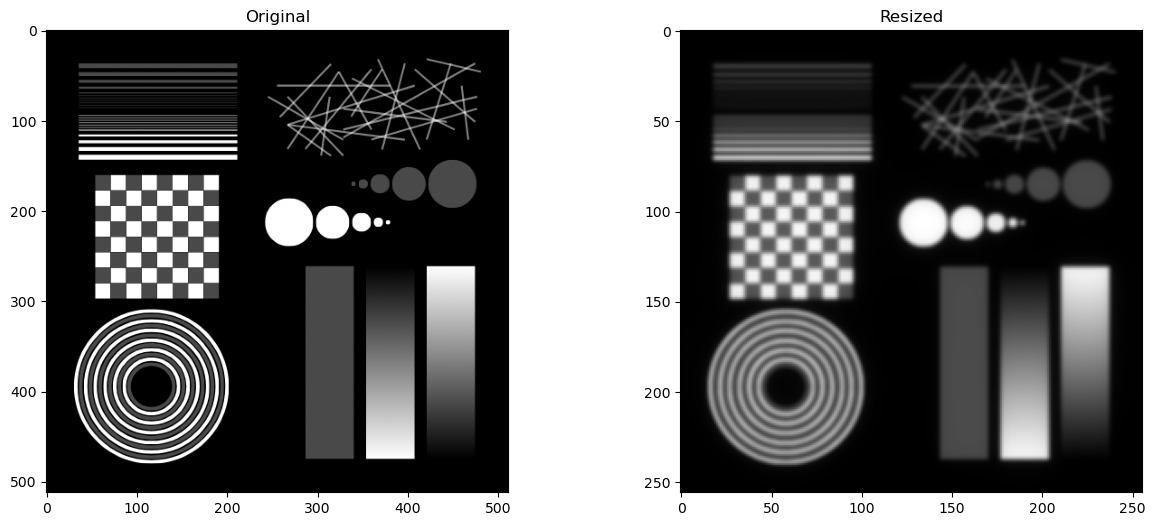

In [3]:
plt.set_cmap('gray')

synthetic = ski.img_as_float(ski.color.rgb2gray(ski.io.imread('source_images\Synthetic512.png')))

# print(np.shape(synthetic), np.min(synthetic), np.max(synthetic))

synthetic256 = op.otf_incoherent(synthetic, NA=1.2, wavelength=680, pixelsize=100)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].imshow(synthetic)
ax[0].set_title("Original")
ax[1].imshow(synthetic256)
ax[1].set_title("Resized")
plt.show()

In [4]:
synthetic_grated = np.zeros((9, synthetic.shape[0], synthetic.shape[1]))

for i in range(3):
    for j in range(3):
        synthetic_grated[3*i + j] = synthetic * op.grating(len(synthetic), 120 * i,  120 * j, NA=1.2, wavelength=680, pixelsize=100)

# Show grated images   
# fig, ax = plt.subplots(1, 3, figsize=(15, 6))
# for i in range(3):
#     ax[i].imshow(synthetic_grated[3*i])
# plt.show()

# op.display_fourier(synthetic_grated[0])
# op.display_fourier(op.otf_incoherent(synthetic_grated[5], NA=1.2, wavelength=600, pixelsize=100))

In [ ]:
# Add noise to the images
percentage = 0.2
folder_path = 'output_images/saltpepper_noise/20percent_noise'
synthetic_grated_gaussian = gauss_noise(synthetic_grated, percentage)
synthetic_grated_poisson = poisson_noise(synthetic_grated, percentage)
synthetic_grated_saltpepper = salt_pepper_noise(synthetic_grated, percentage)
synthetic_grated_random = random_noise(synthetic_grated, percentage)

# Apply low-pass filter
synthetic_grated_gaussian_256 = op.otf_incoherent(synthetic_grated_gaussian, NA=1.2, wavelength=600, pixelsize=100)
synthetic_grated_poisson_256 = op.otf_incoherent(synthetic_grated_poisson, NA=1.2, wavelength=600, pixelsize=100)
synthetic_grated_saltpepper_256 = op.otf_incoherent(synthetic_grated_saltpepper, NA=1.2, wavelength=600, pixelsize=100)
synthetic_grated_random_256 = op.otf_incoherent(synthetic_grated_random, NA=1.2, wavelength=600, pixelsize=100)


In [ ]:
synthetic_grated_256 = op.otf_incoherent(synthetic_grated) # Ground truth
noisy_image = synthetic_grated_saltpepper_256

noisy_PSNR = np.zeros(9)
noisy_SSIM = np.zeros(9)
for i in range(9):
    noisy_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], noisy_image[i])
    noisy_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], noisy_image[i], data_range=1)

print("Noisy PSNR: ", np.mean(noisy_PSNR))
print("Noisy SSIM: ", np.mean(noisy_SSIM))


# op.display_fourier(synthetic_grated_256[0]) # Noise free image
# ski.io.imsave(os.path.join(folder_path, 'noisy_image_256.tif'), noisy_image)

Noisy PSNR:  31.97471123428783
Noisy SSIM:  0.8850172343385806


In [15]:
#Gaussian filter
# sigma = 0.2 # 1% 0.2
# gaussian_synthetic_grated_256 = ski.filters.gaussian(noisy_image, sigma)

# gauss_PSNR = np.zeros(9)
# gauss_SSIM = np.zeros(9)

# for i in range(9):
#     gauss_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], gaussian_synthetic_grated_256[i])
#     gauss_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], gaussian_synthetic_grated_256[i], data_range=1)
    
# print(np.mean(gauss_PSNR))
# print(np.mean(gauss_SSIM))
# ski.io.imsave(os.path.join(folder_path, 'gaussian_synthetic_grated_256.tif'), gaussian_synthetic_grated_256)

In [ ]:
# Wiener filter
psf = op.gaussian_psf(3)
wiener_synthetic_grated_256 = np.zeros((9, 256, 256))

balance = 0.001 # 1% 0.0001

for i in range(9):
    wiener_synthetic_grated_256[i] = ski.restoration.wiener(noisy_image[i], psf, balance)

wiener_PSNR = np.zeros(9)
wiener_SSIM = np.zeros(9)

for i in range(9):
    wiener_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], wiener_synthetic_grated_256[i])
    wiener_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], wiener_synthetic_grated_256[i], data_range=1)
    
print(np.sum(wiener_PSNR, axis=0)/9)
print(np.sum(wiener_SSIM, axis=0)/9)
# ski.io.imsave(os.path.join(folder_path, 'wiener_synthetic_grated_256.tif'), wiener_synthetic_grated_256)

30.63815928039217
0.8608071353862066


In [ ]:
# Total variation filter
tv_synthetic_grated_256 = np.zeros((9, 256, 256))

weight = 0.0001 # 1% 0.0002
for i in range(9):
    tv_synthetic_grated_256[i] = ski.restoration.denoise_tv_chambolle(noisy_image[i], weight)

tv_PSNR = np.zeros(9)
tv_SSIM = np.zeros(9)

for i in range(9):
    tv_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], tv_synthetic_grated_256[i])
    tv_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], tv_synthetic_grated_256[i], data_range=1)

print(np.sum(tv_PSNR, axis=0)/9)
print(np.sum(tv_SSIM, axis=0)/9)
# ski.io.imsave(os.path.join(folder_path, 'tv_synthetic_grated_256.tif'), tv_synthetic_grated_256)

31.985676316447194
0.8856249633648345


In [ ]:
# BM3D filter
bm3d_synthetic_grated_256 = np.zeros((9, 256, 256))
sigma_psd = 0.002 # 1% 0.001
for i in range(9):
    bm3d_synthetic_grated_256[i] = bm3d.bm3d(noisy_image[i], sigma_psd, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

bm3d_PSNR = np.zeros(9)
bm3d_SSIM = np.zeros(9)

for i in range(9):
    bm3d_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], bm3d_synthetic_grated_256[i])
    bm3d_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], bm3d_synthetic_grated_256[i], data_range=1)

print(np.mean(bm3d_PSNR))
print(np.mean(bm3d_SSIM))

# ski.io.imsave(os.path.join(folder_path, 'bm3d_synthetic_grated_256.tif'), bm3d_synthetic_grated_256)

31.99070390111152
0.885915556210783


In [ ]:
# Richardson-Lucy filter
rl_synthetic_grated_256 = np.zeros((9, 256, 256))
psf = op.gaussian_psf(3)
for i in range(9):
    rl_synthetic_grated_256[i] = ski.restoration.richardson_lucy(noisy_image[i], psf, num_iter=30)

rl_PSNR = np.zeros(9)
rl_SSIM = np.zeros(9)

for i in range(9):
    rl_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], rl_synthetic_grated_256[i])
    rl_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], rl_synthetic_grated_256[i], data_range=1)

print(np.mean(rl_PSNR))
print(np.mean(rl_SSIM))

# ski.io.imsave(os.path.join(folder_path, 'rl_synthetic_grated_256.tif'), rl_synthetic_grated_256)

30.585519643890866
0.8600004441797914


In [ ]:
# Create a dictionary to store the data
data = {
    'Filter': ['Noisy', 'Wiener', 'TV', 'BM3D', 'RL'],
    'PSNR': [np.mean(noisy_PSNR), np.mean(wiener_PSNR), np.mean(tv_PSNR), np.mean(bm3d_PSNR), np.mean(rl_PSNR)],
    'SSIM': [np.mean(noisy_SSIM), np.mean(wiener_SSIM), np.mean(tv_SSIM), np.mean(bm3d_SSIM), np.mean(rl_SSIM)]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print("Noisy PSNR: ", np.mean(noisy_PSNR))
print("Noisy SSIM: ", np.mean(noisy_SSIM))
display(df)
# df.to_csv(os.path.join(folder_path, 'filter_results.csv'), index=False)

Noisy PSNR:  31.97471123428783
Noisy SSIM:  0.8850172343385806


,Filter,PSNR,SSIM
0,Noisy,31.974711,0.885017
1,Wiener,30.638159,0.860807
2,TV,31.985676,0.885625
3,BM3D,31.990704,0.885916
4,RL,30.585520,0.860000
